# 95-869: Big Data and Large-Scale Computing Homework 5


## **Yelp Dataset Assignment**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset). It is an opportunity for you to explore machine learning tasks in the context of a real-world data set using big data analysis tools. In order to use the dataset and finish this project, you must agree to the dataset's terms of use provided [here](https://s3-media0.fl.yelpcdn.com/assets/srv0/engineering_pages/dc1cabe7cb95/assets/vendor/Dataset_User_Agreement.pdf).

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset).

#### ** This assignment will cover: **
*  *Part 1 (30 Points):* Exploratory Data Analysis [Link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html) [Link](https://spark.apache.org/docs/1.1.0/api/python/pyspark.mllib.stat.Statistics-class.html)
*  *Part 2 (20 Points):* Prediction using tree ensemble methods [Link](https://spark.apache.org/docs/latest/mllib-ensembles.html)
*  *Part 3 (20 Points):* Collaborative filtering for recommendation [Link](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html)
*  *Part 4 (15 Points):* Topic modeling for text reviews [Link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.LDA.html)
*  *Part 5 (15 Points):* Word2Vec for text reviews [Link](https://spark.apache.org/docs/2.2.0/mllib-feature-extraction.html#word2vec)


#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Code of Conduct **

** Please follow the following guidelines with respect to collaboration: **

* By using the dataset, you agree to Yelp's terms of use available [here](https://s3-media0.fl.yelpcdn.com/assets/srv0/engineering_pages/dc1cabe7cb95/assets/vendor/Dataset_User_Agreement.pdf).
* You are free to use the Web, APIs, ML toolkits, etc. in this project to your best benefit. Please cite any online or offline sources (even casual sources like StackOverflow) if you use them in the project.
* The assignment is to be done individually. No collaboration is allowed between students. No discussion is allowed about the project with anyone else except the class instructors.

** No late days is allowed in this assignment. **

## Submission Instructions:

You will submit both a PDF and an IPython file on Canvas and gradescope. No printout submission is expected.

Rename the notebook from "hw5_yelp_student.ipynb" to "andrewid_hw5_yelp_student.ipynb" where "andrewid" is your actual Andrew ID. Complete the assignment, execute all cells in the completed notebook, and make sure all results show up. Export the contents of the notebook by choosing "File > Download as > HTML" and saving the resulting file as "andrewid_hw5_yelp_student.html" Convert the exported HTML file to PDF by using a feature such as the "Save as PDF" feature on Mac. Submit the IPython and exported PDF solution files on Canvas and the PDF on gradescope.

# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Let's first start by creating the SparkContext.

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()
sc = spark.sparkContext

In [2]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents, numSlices=1000)
    return rdd 

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [3]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [4]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/ocean/projects/cie170025p/shared/data/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/ocean/projects/cie170025p/shared/data/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.

Please replace `<FILL IN>` with your solution. This is the general form that exercises will take. Exercises will include an explanation of what is expected, followed by code cells where one cell will have one or more `<FILL IN>` sections.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715
Number of checkins:  45166
Number of reviews:  62608


** Question1: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
# TODO: Replace <FILL IN>
categ_count = businesses_rdd.flatMap(lambda x : [(c,1) for c in x['categories']]).countByKey()
sorted(categ_count.items(), reverse=True, key = (lambda x:x[1]))[:5]

[('Restaurants', 21892),
 ('Shopping', 8919),
 ('Food', 7862),
 ('Beauty & Spas', 4738),
 ('Nightlife', 4340)]

** Question2: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
# TODO: Replace <FILL IN>

cities_count = businesses_rdd.map(lambda x:(x['city'],1)).countByKey()
sorted(cities_count.items(), reverse=True, key = (lambda x:x[1]))[:5]

[('Las Vegas', 13601),
 ('Phoenix', 8410),
 ('Charlotte', 4224),
 ('Scottsdale', 4039),
 ('Edinburgh', 3031)]

** Question3: ** Plot the histogram of stars received by businesses.

Text(0, 0.5, 'Number of Businesses')

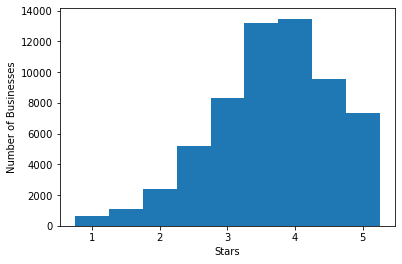

In [11]:
# TODO: Replace <FILL IN>

businesses_stars_counts = businesses_rdd.map(lambda x:x['stars']).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question4: ** Plot the histogram of number of reviews received by businesses.

Text(0, 0.5, 'Number of Businesses')

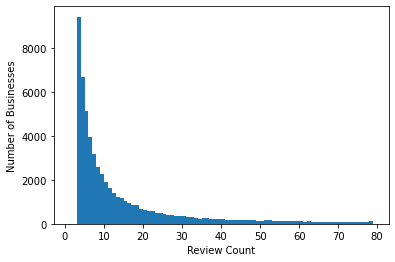

In [12]:
# TODO: Replace <FILL IN>

businesses_review_counts = businesses_rdd.map(lambda x:x['review_count']).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question5: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, it is consistent with the power law. The number of businesses with higher review count is lower than the number of businesses with a lesser review count. Therefore, number of reviews and their frequency is inversely proportional as the power of the each other.  

Text(0, 0.5, 'Number of Businesses')

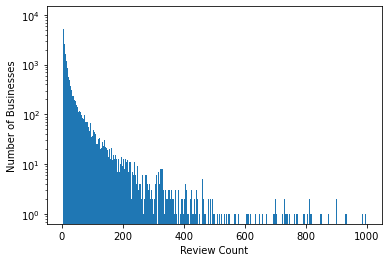

In [13]:
# TODO: Replace <FILL IN>
businesses_review_counts = businesses_rdd.map(lambda x:x['review_count']).collect()
plt.hist(businesses_review_counts, bins=range(1,1000),log=True)
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question6: ** Plot the histogram of number of reviews written by users.

Text(0, 0.5, 'Number of Users')

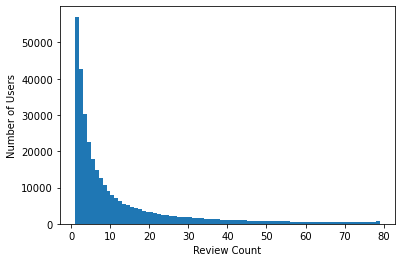

In [14]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda x:x['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question7: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, the power law holds. The number of reviews given per user is inversely proportional to their frequency and they vary as the power of each other. Less number of people have given higher number of reviews 

Text(0, 0.5, 'Number of Users')

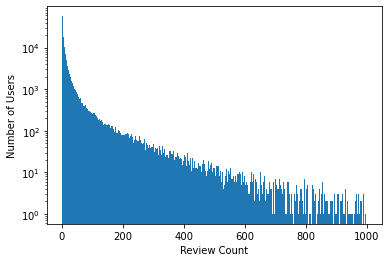

In [15]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda x:x['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,1000),log=True)
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question8: ** Plot the histogram of number of friends a Yelp user has.

Text(0, 0.5, 'Number of Users')

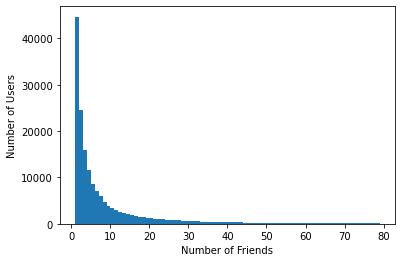

In [16]:
# TODO: Replace <FILL IN>

user_friend_counts = users_rdd.map(lambda x:len(x['friends'])).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question9: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, there is a power law relationnship. A lot of users have low number of friends and the number of users with more number of friends gets lesser as the number of friends increases, there is an inverse relationship - one quantity varies as the power of the other. 

Text(0, 0.5, 'Number of Users')

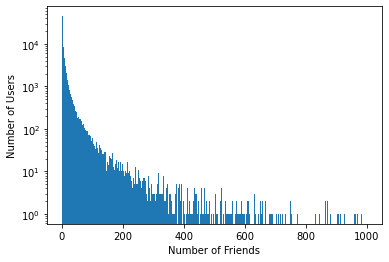

In [17]:
# TODO: Replace <FILL IN>

user_friend_counts = users_rdd.map(lambda x:len(x['friends'])).collect()

plt.hist(user_friend_counts, bins=range(1,1000), log=True)
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question10: ** Plot the histogram of number of fans a Yelp user has.

Text(0, 0.5, 'Number of Users')

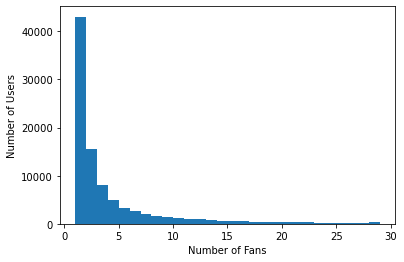

In [18]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda x:x['fans']).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question11: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, there is a power law relationnship. A lot of users have low number of fans and the number of users with more number of fans gets lesser as the number of fans increases, there is an inverse relationship - one quantity varies as the power of the other. 

Text(0, 0.5, 'Number of Users')

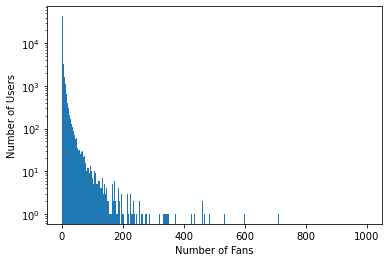

In [19]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda x:x['fans']).collect()

plt.hist(users_fan_counts, bins=range(1,1000), log=True)
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question12: ** Plot the histogram of number of checkins per Yelp business.

Text(0, 0.5, 'Number of Businesses')

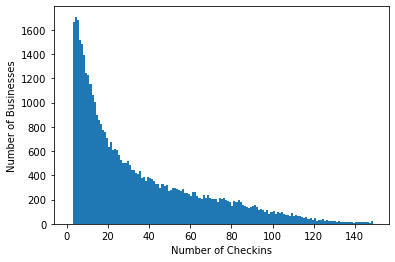

In [23]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda x:len(x['checkin_info'])).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question13: ** Plot the above histogram but now on a log-log scale using `bins=range(3,200)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** The power law relationship is not very clear. The inverse relationship is not very obvious and it does not look like number of checkins does not vary as the power of its frequency


Text(0, 0.5, 'Number of Businesses')

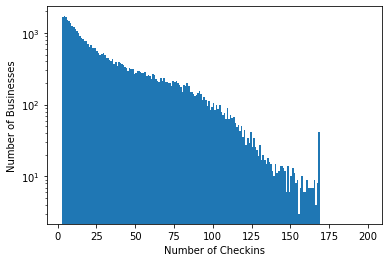

In [25]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda x:len(x['checkin_info'])).collect()

plt.hist(business_checkin_counts, bins=range(3,200),log=True)
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question14: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [27]:
# TODO: Replace <FILL IN>

max_checkin_count = checkins_rdd.map(lambda x:len(x['checkin_info'])).max()
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda x: len(x['checkin_info']) == max_checkin_count) \
    .map(lambda x:x['business_id']).collect()
len(business_ids_with_max_checkins)

41

In [28]:
# TODO: Replace <FILL IN>

business_names_with_max_checkins = businesses_rdd \
    .filter(lambda x:x['business_id'] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas'),
 ('McCarran International Airport', 'Las Vegas'),
 ('The California Hotel & Casino', 'Las Vegas'),
 ('Golden Nugget Hotel & Casino', 'Las Vegas'),
 ('Rio All Suites Hotel & Casino', 'Las Vegas'),
 ('24 Hour Fitness', 'Las Vegas'),
 ('Excalibur Hotel', 'Las Vegas'),
 ('Ellis Island Casino & Brewery', 'Las Vegas'),
 ('Las Vegas Athletic Club', 'Las Vegas'),
 ('Orleans Hotel & Casino', 'Las Vegas'),
 ('Palms Casino Resort', 'Las Vegas'),
 ('Bellagio Hotel', 'Las Vegas'),
 ('New York - New York', 'Las Vegas'),
 ('Paris Las Vegas Hotel & Casino', 'Las Vegas'),
 ('Monte Carlo Hotel And Casino', 'Las Vegas'),
 ('The Venetian Resort Hotel Casino', 'Las Vegas'),
 ('The Mirage', 'Las Vegas'),
 ('MGM Grand Hotel', 'Las Vegas'),
 ('Treasure Island, LLC', 'Las Vegas'),
 ('The Peppermill Restaurant & Fireside Lounge', 'Las Vegas'),
 ('Flamingo Las Vegas

** Question15: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** Most of these are famous/luxurious casinos or airports in Las Vegas. Most people are likely to check-in to such places that they visit occasionally and not regularly like restaurants.

** Question16: ** Plot a histogram of the stars associated with business reviews.

Text(0, 0.5, 'Number of Reviews')

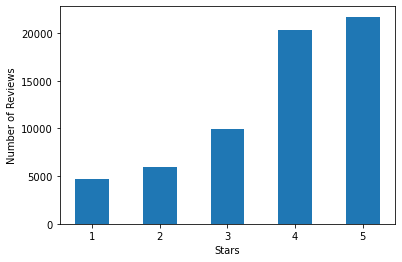

In [29]:
# TODO: Replace <FILL IN>

review_stars_counts = reviews_rdd.map(lambda x:x['stars']).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question17: ** Plot a histogram of the number of reviews written per Yelp user.

Text(0, 0.5, 'Number of Users')

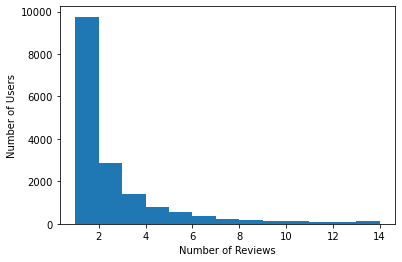

In [30]:
# TODO: Replace <FILL IN>

user_review_counts = list(reviews_rdd.map(lambda x:(x['user_id'],1)).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question18: ** Plot a histogram of the number of reviews written per Yelp business.

Text(0, 0.5, 'Number of Businesses')

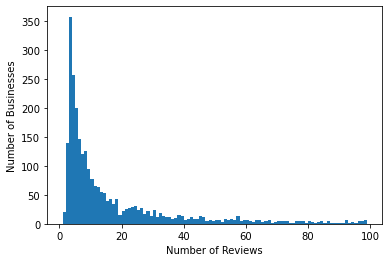

In [31]:
# TODO: Replace <FILL IN>

business_review_counts = list(reviews_rdd.map(lambda x:(x['business_id'],1)).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

** Question19: ** Plot a histogram of the number of useful votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

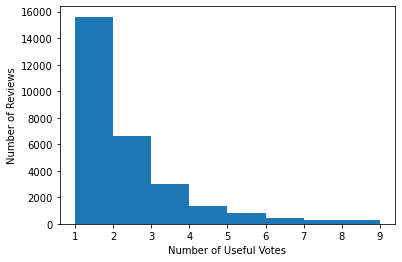

In [32]:
# TODO: Replace <FILL IN>

review_useful_counts = reviews_rdd.map(lambda x:x['votes']['useful']).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question20: ** Plot a histogram of the number of funny votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

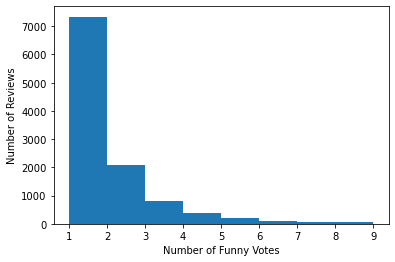

In [33]:
# TODO: Replace <FILL IN>

review_funny_counts = reviews_rdd.map(lambda x:x['votes']['funny']).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question21: ** Plot a histogram of the number of cool votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

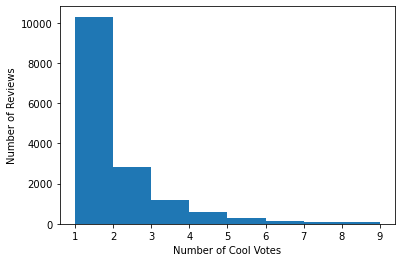

In [34]:
# TODO: Replace <FILL IN>

review_cool_counts = reviews_rdd.map(lambda x:x['votes']['cool']).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question22: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

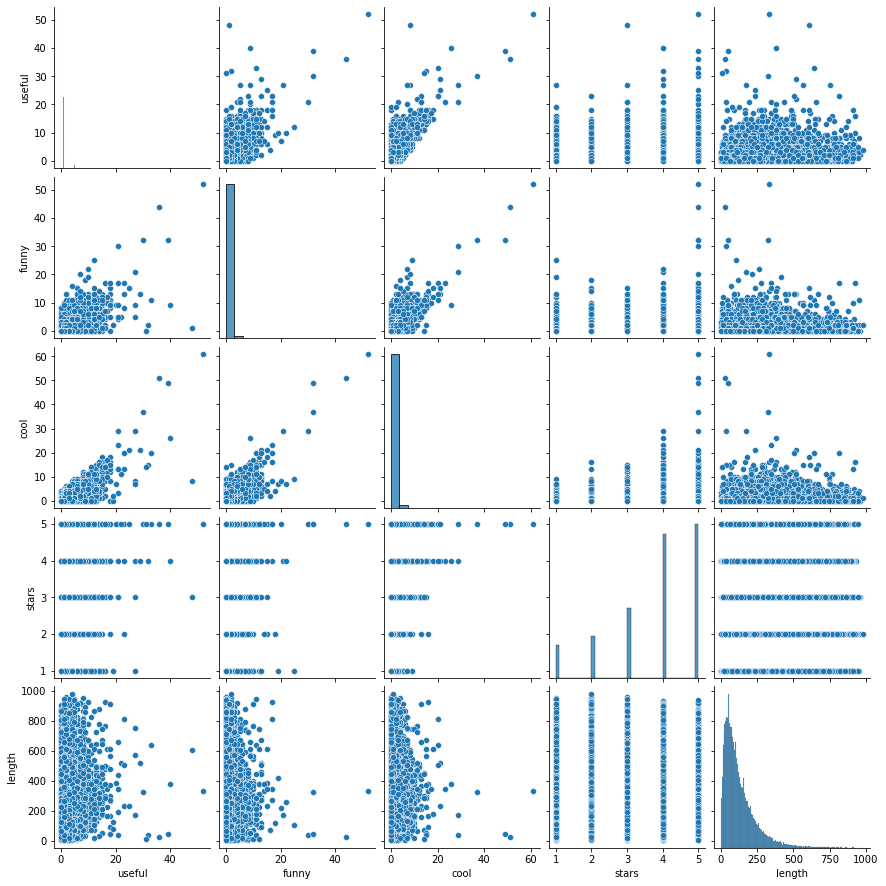

In [35]:
# TODO: Replace <FILL IN>

review_votes_length = reviews_rdd.map(lambda x:(x['votes']['useful'],x['votes']['funny'],x['votes']['cool'],x['stars'],len(x['text'].split()))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question23: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [36]:
# TODO: Replace <FILL IN>

male_users = users_rdd.filter(lambda x:x['name'] in male_names)
female_users = users_rdd.filter(lambda x:x['name'] in female_names)

male_user_ids = male_users.map(lambda x:x['user_id']).collect()
female_user_ids = female_users.map(lambda x:x['user_id']).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869
366715


** Question24: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [37]:
# TODO: Replace <FILL IN>

male_reviews = reviews_rdd.filter(lambda x:x['user_id'] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda x:x['user_id'] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda x:len(x.split()))
female_word_count = female_reviews.map(lambda x:len(x.split()))

print ('Male and female review length averages: ', male_word_count.mean(),  female_word_count.mean())

Male and female review length averages:  127.3470787972136 139.21062276751053


** Question25: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** No there is not much difference in the average length of reviews between male and female users. There is only a difference of 12 words on average. Moreover, they follow the similar trends as seen in the plot. The blue and orange lines almost coincide with each other. 

In [40]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

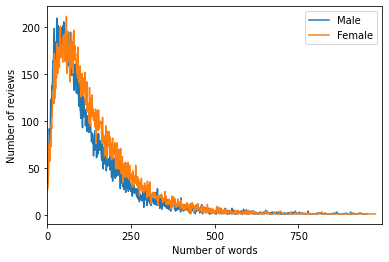

In [41]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [44]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

** Question1: ** Fill in the necessary code to calculate word counts from text reviews below.

In [45]:
# TODO: Replace <FILL IN>

max_words = 30000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x:[w for w in x[0].split()]).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  30000


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [46]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [47]:
from pyspark.mllib.linalg import SparseVector

In [48]:
def sparseDic(num,dense):
    sparse_dict={}
    for i in range(len(dense)):
        if dense[i] not in list(sparse_dict.keys()):
            sparse_dict[dense[i]]=1
        else:
            sparse_dict[dense[i]]+=1
    
    return SparseVector(num,sparse_dict)

In [49]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0],sparseDic(num_unique_words,x[1])))
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (30000,[0,1,2,4,6,8,9,12,13,15,16,19,20,25,38,42,49,58,86,107,114,125,164,168,189,204,208,233,297,301,344,352,364,365,465,471,490,669,684,767,781,942,1003,1014,1106,1148,1360,1912,2283,2414,2960,3413,3958,4179,4356,4423,4779,4806,4968,5327,5743,6021,6022,6057,6268,9594,14463,14848,15307,16821,16822,17427,26734],[8.0,3.0,1.0,5.0,5.0,1.0,1.0,1.0,2.0,4.0,6.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (30000,[0,4,5,8,9,17,19,35,36,41,45,55,71,77,87,99,101,132,201,239,306,316,326,331,364,367,377,446,471,607,610,649,914,939,994,2960,3542,6587,6709,10548,15761,18035,20358],[2.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))

** Question4: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [50]:
# TODO: Replace <FILL IN>

doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit([0.8,0.2])

** Question5: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [51]:
# TODO: Replace <FILL IN>

most_common_prediction = sorted(doc_vectors.map(lambda x:(x.label,1)).countByKey().items(),reverse=True,key = (lambda x:x[1]))[0][0]
labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 1.0100550634426622
Learned baseline prediction:  0.0


** Question6: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [52]:
# TODO: Replace <FILL IN>

dt_model = DecisionTree.trainRegressor(doc_vectors_train,maxDepth=5, impurity="variance",categoricalFeaturesInfo = {})

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

Validation Root Mean Squared Error (Decision Tree) = 1.1321995165652368
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 17 nodes
  If (feature 22760 <= 1.5)
   If (feature 5 <= 3.5)
    If (feature 21655 <= 1.5)
     If (feature 3879 <= 2.5)
      If (feature 2138 <= 1.5)
       Predict: 0.23086618937178582
      Else (feature 2138 > 1.5)
       Predict: 6.666666666666667
     Else (feature 3879 > 2.5)
      Predict: 20.0
    Else (feature 21655 > 1.5)
     Predict: 32.0
   Else (feature 5 > 3.5)
    If (feature 19697 <= 0.5)
     If (feature 4279 <= 1.5)
      If (feature 7612 <= 1.5)
       Predict: 0.5869732538002694
      Else (feature 7612 > 1.5)
       Predict: 17.0
     Else (feature 4279 > 1.5)
      Predict: 19.0
    Else (feature 19697 > 0.5)
     Predict: 32.0
  Else (feature 22760 > 1.5)
   Predict: 52.0



** Question7: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [53]:
# TODO: Replace <FILL IN>

rf_model = RandomForest.trainRegressor(doc_vectors_train,maxDepth=5,numTrees=10,categoricalFeaturesInfo = {})

predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

Validation Root Mean Squared Error (Random Forest) = 0.9145562741360146
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 0 <= 9.5)
     If (feature 24056 <= 0.5)
      If (feature 104 <= 4.5)
       If (feature 27770 <= 0.5)
        If (feature 4 <= 2.5)
         Predict: 0.17819728608591717
        Else (feature 4 > 2.5)
         Predict: 0.3523756993144748
       Else (feature 27770 > 0.5)
        Predict: 13.0
      Else (feature 104 > 4.5)
       If (feature 14 <= 0.5)
        Predict: 21.0
       Else (feature 14 > 0.5)
        If (feature 1 <= 1.5)
         Predict: 0.0
        Else (feature 1 > 1.5)
         Predict: 8.0
     Else (feature 24056 > 0.5)
      If (feature 4 <= 1.5)
       Predict: 0.0
      Else (feature 4 > 1.5)
       Predict: 32.0
    Else (feature 0 > 9.5)
     If (feature 19697 <= 0.5)
      If (feature 21586 <= 0.5)
       If (feature 26884 <= 0.5)
        If (feature 26203 <= 2.0)
         Predict: 0.60028402

** Question8: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: ** Yes, it affects the number of trees, which increases with the number of iterations. Infact, the number of iterations is equivalent to the number of trees. Yes, the maximum depth of trees is the regularization parameter and needs to be set. The best can be found through hyperparameter tuning. The default depth in this Mllib method is 3. The lesser the depth, more number of iterations are required. 

In [54]:
# TODO: Replace <FILL IN>

gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train,numIterations=10,categoricalFeaturesInfo = {})

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

Validation Root Mean Squared Error (Gradient Boosting Trees) = 1.112837885959837
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 22760 <= 1.5)
     If (feature 5 <= 3.5)
      If (feature 21655 <= 1.5)
       Predict: 0.23282423509249459
      Else (feature 21655 > 1.5)
       Predict: 32.0
     Else (feature 5 > 3.5)
      If (feature 19697 <= 0.5)
       Predict: 0.5903232012312428
      Else (feature 19697 > 0.5)
       Predict: 32.0
    Else (feature 22760 > 1.5)
     Predict: 52.0
  Tree 1:
    If (feature 3 <= 5.5)
     If (feature 2138 <= 1.5)
      If (feature 6754 <= 1.5)
       Predict: -0.09343395799073347
      Else (feature 6754 > 1.5)
       Predict: 32.81935359753743
     Else (feature 2138 > 1.5)
      If (feature 2 <= 0.5)
       Predict: 87.53435152981501
      Else (feature 2 > 0.5)
       Predict: 3.1464946823467983
    Else (feature 3 > 5.5)
     If (feature 146 <= 0.5)
      If (feature 5310 <= 2.5)
       Predict

** Question9: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** Random Forest. 

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [8]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question1: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [9]:
# TODO: Replace <FILL IN>

review_user_ids = reviews_rdd.map(lambda x:x['user_id']).distinct().collect()
review_business_ids = reviews_rdd.map(lambda x:x['business_id']).distinct().collect()

user_to_index_dict = {review_user_ids[i]:i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]:i for i in range(len(review_business_ids))}

** Question2: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [10]:
# TODO: Replace <FILL IN>

ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']],business_to_index_dict[x['business_id']], float(x['stars'])))
print(ratings_rdd.take(2))

[Rating(user=15903, product=910, rating=5.0), Rating(user=11610, product=910, rating=2.0)]


** Question3: ** Let us randomly split data into 80% train and 20% validation set.

In [11]:
# TODO: Replace <FILL IN>

ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8,0.2])

** Question4: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

In [12]:
# TODO: Replace <FILL IN>

numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd,rank, numIterations)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

Root Mean Squared Error (rank=1) = Train 1.7354905319792981, Validation 1.713811938338926
Root Mean Squared Error (rank=2) = Train 1.1675745172600867, Validation 1.1508188910749542
Root Mean Squared Error (rank=3) = Train 0.6498814908053742, Validation 0.6403830428305097
Root Mean Squared Error (rank=4) = Train 0.5642989625162428, Validation 0.5491797767518213
Root Mean Squared Error (rank=5) = Train 0.515914529328698, Validation 0.5095977707632405
Root Mean Squared Error (rank=6) = Train 0.48439150074664983, Validation 0.47215036709587077
Root Mean Squared Error (rank=7) = Train 0.44579646015620455, Validation 0.4245170254296947
Root Mean Squared Error (rank=8) = Train 0.4114166645407885, Validation 0.3973282216985231
Root Mean Squared Error (rank=9) = Train 0.38937131356242777, Validation 0.37205105939979977
Root Mean Squared Error (rank=10) = Train 0.36657907661234534, Validation 0.34911589947692384
Root Mean Squared Error (rank=11) = Train 0.34791156310061916, Validation 0.32298131

** Question5: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** My choice of the best rank hyperparameter would be 40. Infact, any rank value after 40 is acceptable because the training and validation RMSE plateaus or becomes constant for rank values beyond that. But if using higher rank values are computationally expensive, we can use 40. 

This choice is conclusive because from 40-200 all the rank values have resulted in the almost the same RMSE values. Thus, there is no need to conduct a more extensive hyperparameter search at larger ranks. 

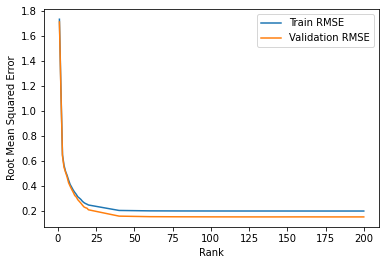

In [13]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Topic modeling for text reviews **

In this section, we will build and examine a Bayesian topic model named [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). The goal of textual topic modeling is to discover latent topics whose mixtures generate textual documents through a stylized probabilistic generatve model. The topics often have semantic meaning. They may be associated with various aspects discussed in the text corpus such as politics, health, education, etc. Topic models are unsupervised machine learning algorithms. Hence, the nature of discovered topics is entirely dependent of the context of your dataset.

In [10]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

** Question1: ** Let us create a new RDD of just textual reviews from reviews_rdd, obtain word counts, and build a list of unique words that do not include stop words. Use num_stop_words as a measure of how many of the most frequent words to filter out.

In [11]:
# TODO: Replace <FILL IN>

# number of stopwords i.e. most frequent words to remove
# removal of stopwords such as a, the, from, etc. that occur across a vast majority of documents improves topic models
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda x:x['text'])
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
# sort words in descending order of frequency
word_counts = sorted(word_counts, key=lambda x: -x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  192742


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [12]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Construct an RDD of SparseVectors. Each SparseVector is built using the word counts of a review. Hence, the RDD of SparseVectors should be obtained as a map from the RDD of document word counts.

In [15]:
# TODO: Replace <FILL IN>

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
doc_vectors = doc_vectors.map(lambda x: sparseDic(num_unique_words,x))
# zipWithIndex result needs a minor transform to be acceptable to the LDA training procedure
doc_vectors = doc_vectors.zipWithIndex().map(lambda x:[x[1],x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[[0, SparseVector(192742, {8: 2.0, 114: 1.0, 311: 1.0, 1209: 1.0, 1315: 1.0, 1444: 1.0, 1805: 1.0, 1987: 1.0, 2249: 1.0, 2738: 1.0, 2965: 1.0, 3148: 1.0, 3166: 1.0, 3530: 1.0, 3614: 1.0, 3977: 1.0, 4305: 1.0, 4391: 1.0, 4700: 1.0, 6041: 1.0, 8947: 1.0, 11064: 1.0, 13456: 1.0, 14371: 1.0, 23207: 1.0, 54812: 1.0, 77509: 1.0, 77510: 1.0, 77511: 1.0, 77512: 1.0})], [1, SparseVector(192742, {1805: 1.0, 2231: 1.0, 4799: 1.0, 5281: 1.0, 8776: 1.0, 12656: 1.0, 15459: 1.0, 17524: 1.0})]]


** Question4: ** Train an LDA model with a 100 topics and the random seed set to 42.

In [16]:
# TODO: Replace <FILL IN>

lda_model = LDA.train(doc_vectors,k=100, seed=42)

** Question5: ** Display the LDA model vocabulary size.

In [17]:
# TODO: Replace <FILL IN>

print('Model vocabulary size: ', lda_model.vocabSize())

Model vocabulary size:  192742


** Question6: ** Display 5 learned topics and the top 100 terms that appear in each of these topics. Assign a semantic label/meaning to each of them (e.g. food, ambience, drinks, service, etc.) You can access the topic matrix using the function topicsMatrix on the model. Do the topics learned from Yelp reviews look representative of the corpus?

** Answer: ** 
Topic 1 - Menu because of words like choices, limited, paying, times
Topic 2 - Ambience because of words like small, wall, atmosphere, room
Topic 3 - Food because of words like burrito, bean, finished, pepper, sour, pancakes
Topic 4 - Food because of words like noodle, bean, sour, pepper
Topic 5 - Service because of words like thank, they've, times, please


Yes, they look representative of the corpus because these are the words that the Yelp users usually use in their restaurant reviews

In [24]:
# TODO: Replace <FILL IN>

for i,topics in enumerate(lda_model.describeTopics(100)[:5]):
    word_indices = topics[0]
    print("\nTopic ",(str(i+1)))
    for idx in word_indices:
        print(index_to_word_dict[idx])


Topic  1
charge
up,
bottom
true
pancakes
you'd
great!
thick
covered
choices
limited
paying
best.
generally
times.
orders
stayed
sign
thinking
forget
wall
thank
room.
pizza,
sour
pepper
general
card
somewhere
life
recommended
please
meal,
hand
penn
area,
right.
location.
tasty,
atmosphere,
is,
personal
chili
mine
minute
pricey
seriously
avoid
terrible
clearly
finished
noodle
employees
share
inside.
town.
greasy
small,
visit.
means
except
they've
else.
you,
dogs
dressing
we're
apple
side,
station
rooms
bread.
original
total
oakland
special.
works
okay,
...
cook
picked
them,
waffle
kinda
(not
and,
perfect.
fresh.
nearly
amazing!
selection.
play
,
bean
oil
thin
longer
bunch
minutes.
recent

Topic  2
choices
covered
general
pepper
thick
bean
bottom
charge
finished
room.
up,
times.
sign
tasty,
wall
best.
you'd
true
paying
somewhere
side,
generally
forget
sour
except
clearly
limited
pricey
please
pancakes
personal
seriously
apple
thank
dressing
they've
meal,
great!
small,
creamy
mine
cook
oi

# ** Part 5: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [55]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [56]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question1: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [59]:
# TODO: Replace <FILL IN>

word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).setNumIterations(10).fit(review_docs)

Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [60]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['cholula', 'fluff', 'burst', 'smear', 'coarse']
Words most similar to  pepper  :  ['stewed', 'garlic', 'deep', 'sriracha', 'ranch']
Words most similar to  restaurant  :  ['resturant', 'restaraunt', 'establishment', 'location', 'soho']
Words most similar to  italian  :  ['style', 'shacks', 'greek', 'neopolitan', 'traditional']
Words most similar to  indian  :  ['chinese', 'chinesetaiwanese', 'mexican', 'japanese', 'cuisine']
Words most similar to  chinese  :  ['indian', 'chinesetaiwanese', 'mexican', 'japanese', 'korean']
Words most similar to  direction  :  ['driveway', 'greyhound', 'post', 'tripadvisor', 'apartment']
Words most similar to  pittsburgh  :  ['pgh', 'connecticut', 'burgh', 'bloomfield', 'new']
Words most similar to  burgh  :  ['lebanon', 'city', 'berlin', 'lebo', 'burg']
Words most similar to  city  :  ['robinson', 'hiptique', 'burg', 'bloomfield', 'northside']
Words most similar to  location  :  ['toonseum', 'neighborhood', 'scene', 'time

** Question2: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: ** The synonyms for cmu - college, school, campus, undergrad are good analogies. Similarly different spellings of restaurant like resturant, restaraunt, establishment are good analogies. There are also spurious substitutes like tripadvisor, apartment for direction and berlin, lebo, lebanon for pittsburgh. 

# ** Part 6: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [21]:
from pyspark.mllib.fpm import FPGrowth

** Question1: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [24]:
# TODO: Replace <FILL IN>

business_categories = businesses_rdd.map(lambda x:set(x['categories']))

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.01, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

Question2: Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [25]:
# TODO: Replace <FILL IN>

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.001, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question3: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: ** Yes, all the itemsets obtained by setting minimum support 0.01 are included in the itemsets obtained when we set the minimum support to 0.001. This is because more number of items are obtained by setting a lower threshold support and by increasing the support, we just restrict some itemsets from being included. 

# ** Part 7: Bonus Analysis (if any) **

Here, you can include any additional and insightful exploratory data analysis or machine learning tasks you have carried out in addition to the guided exploration of the dataset above. Feel free to add code/markdown cells here to present your analysis.